使用Keras的预训练模型

只需一行代码即可轻松获得预训练的网络

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from tensorflow import keras
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [2]:
# 创建一个resnet50模型并下载在imagenet数据集上预先训练的权重
model = keras.applications.resnet50.ResNet50(weights="imagenet")


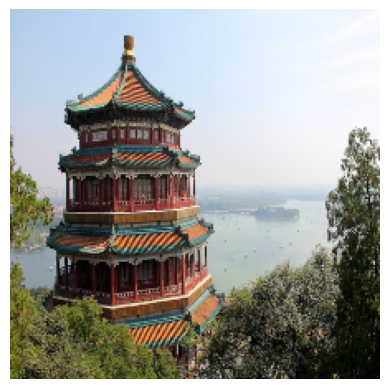

In [3]:
# 使用tf.image.resize()调整加载图像的大小，但不保留宽高比
# 是因为resnet50需要224 224像素的图像
images_resized = tf.image.resize(images, [224, 224])
plt.imshow(images_resized[0])
plt.axis('off')
plt.show()

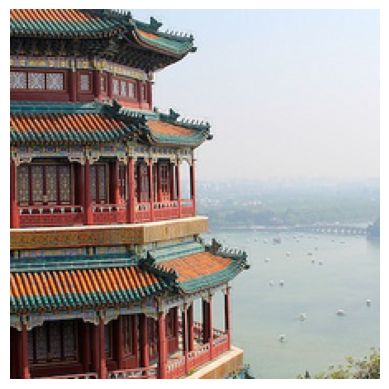

In [4]:
# 将图像裁剪成成合适的宽高比，然后调整图像大小
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plt.imshow(images_resized[0])
plt.axis('off')
plt.show()

预先训练的模型假定以特定方式对图像进行预处理

In [5]:
# 函数假定输入像素值范围是0~255
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
# 每个图像一行，每个类一列
Y_proba = model.predict(inputs)

1/1 [==============================] - 3s 3s/step


In [6]:
# 每个图像一行，每个类一列
Y_proba.shape

(2, 1000)

In [7]:
# 如果要显示前K个预测（包括类名和每个预测类的估计概率）
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    # 提供格式化的分类预测概率输出
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print("\t{} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))

Image #0
	n03877845 - palace       92.34%
	n03781244 - monastery    5.34%
	n02825657 - bell_cote    0.94%
Image #1
	n04522168 - vase         38.41%
	n07930864 - cup          8.87%
	n11939491 - daisy        8.11%


pretrained models for transfer learning

迁移学习的预训练模型

In [8]:
# 使用tensorflow_datasets包，P363
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ['dandelion', 'daisy',...]
n_classes = info.features["label"].num_classes # 5

使用全新的tensorflow数据集分割

https://www.tensorflow.org/datasets/splits

In [9]:

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

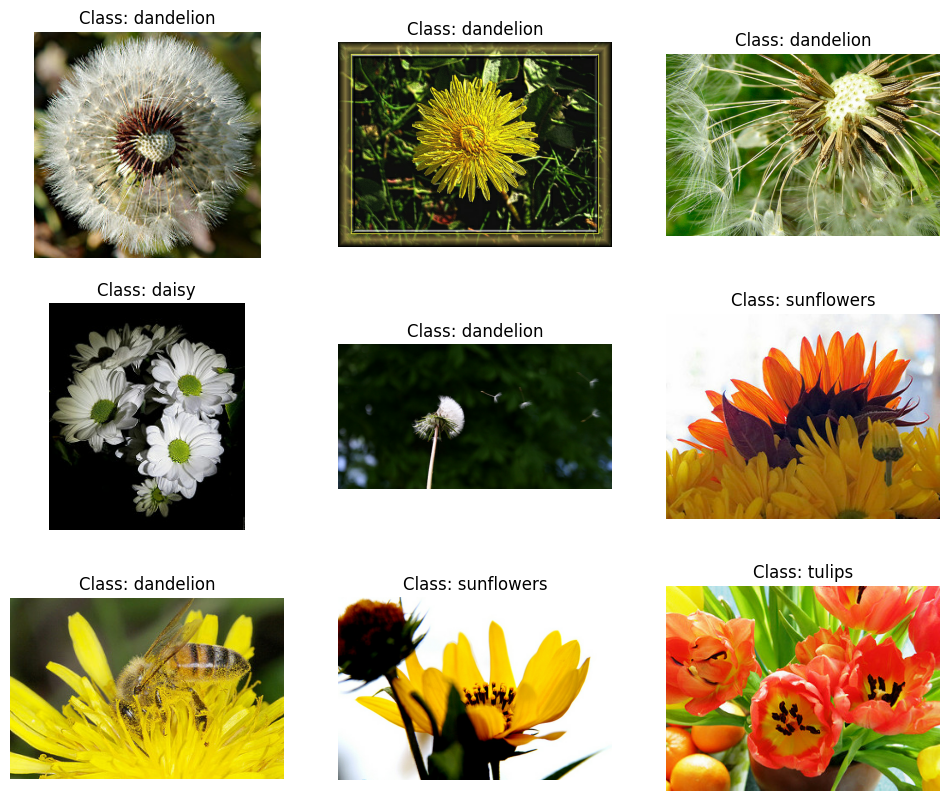

In [10]:
# 绘图，绘制每一类的示例图
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

CNN需要224X224大小的图像，故需要调整图像的大小

In [11]:
# 通过Xception的preprocess_input()函数来预处理图像
def preprocess(image, label):
    resize_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resize_image)
    return final_image, label
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [12]:
# 这块我是真的不知道在干什么
# 用预处理函数来处理所有三个数据集，对训练集进行乱序
# 并对所有数据集添加批量处理和预取
bbatch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

加载一个在imagenet上预训练的xception模型。

include_top=False排除网络的顶部：全局平均池化层和密集输出层

然后根据基本模型的输出，添加自己的全局平均池化层和 每个类一个单位的密集输出层，使用softmax激活函数

In [13]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [14]:
# 如11章所述，至少在训练开始时冻结预训练层的权重通常是一个好主意
# 把backbones冻结起来，可以防止最初几次迭代中权重被破坏
# backbones是用于提取特征的主干网络，一般用现成的VGG resnet
for layer in base_model.layers:
    layer.trainable = False
# 由于我们的模型使用base_model的层，而不是使用base_model对象本身
# 因此设置base_model.trainable = False无效

最后，编译模型并开始训练

In [15]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
1376/1376 [==============================] - 32s 21ms/step - loss: 8.1027 - accuracy: 0.8216 - val_loss: 5.5811 - val_accuracy: 0.8455
Epoch 2/5
1376/1376 [==============================] - 27s 20ms/step - loss: 2.8166 - accuracy: 0.9001 - val_loss: 4.3849 - val_accuracy: 0.8582
Epoch 3/5
1376/1376 [==============================] - 27s 20ms/step - loss: 1.9503 - accuracy: 0.9088 - val_loss: 3.8859 - val_accuracy: 0.8655
Epoch 4/5
1376/1376 [==============================] - 27s 20ms/step - loss: 1.8784 - accuracy: 0.9062 - val_loss: 3.7727 - val_accuracy: 0.8800
Epoch 5/5
1376/1376 [==============================] - 27s 20ms/step - loss: 1.6798 - accuracy: 0.9179 - val_loss: 3.7239 - val_accuracy: 0.8745


现在顶层依据受过了良好的训练，因此我们准备解冻所有层，并继续进行训练，这次我们使用低得多的学习率来避免损坏预训练的权重

In [18]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

with tf.device('/gpu:0'):              
    history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
 636/1376 [============>.................] - ETA: 43s - loss: 1.6063 - accuracy: 0.2162

KeyboardInterrupt: 